In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
# Right after importing seaborn (could also use 'whitegrid')
sns.set_theme(style='darkgrid', context='talk')

import warnings
warnings.filterwarnings('ignore')

from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
from numpy import sqrt
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')
pd.plotting.register_matplotlib_converters()
import copy
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [2]:
data=pd.read_csv('data_cleaned.csv', parse_dates=['date'], index_col=0)
data.head()

,order_id,date,item_code,quantity,unit_price_vat_excl,unit_cogs,net_revenue,gross_revenue,margin_revenue,country,item_name,style,name,group0,group1,category
0,1900052301.000,2019-06-04,ZB00025746,1,9.412,0.000,9.412,0.000,9.412,Romania,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
1,1900100835.000,2019-07-15,ZB00025746,1,8.649,5.393,8.649,5.393,3.255,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
2,1900106577.000,2019-07-24,ZB00025746,1,8.649,5.459,8.649,5.459,3.190,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
3,1900111398.000,2019-08-01,ZB00025746,1,8.649,5.440,8.649,5.440,3.209,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
4,1900052301.000,2019-06-04,ZB00022010,1,12.785,4.088,12.785,4.088,8.697,Romania,NK MERC LT GRD,sp2120-703,Nike,Equipment,Guards,football


In [3]:
def select_series(data, time_period='month', revenue='net'):
    time_periods = {
        'day': 'D',
        'week': 'W',
        'month': 'MS'}
    
    revenue_cat = {
        'net':'net_revenue',
        'gross':'gross_revenue',
        'margin':'margin_revenue'}
    
    data = data.set_index('date')
    data = data[revenue_cat[revenue]].resample(time_periods[time_period]).sum()
    data = pd.DataFrame(data).reset_index()
    return data

In [4]:
monthly_sales=select_series(data)
monthly_sales.columns=['ds', 'y']
monthly_sales.sort_values('ds')
monthly_sales

,ds,y
0,2019-06-01,801413.623
1,2019-07-01,1106329.650
2,2019-08-01,1517582.612
3,2019-09-01,1320894.443
4,2019-10-01,1074520.576
5,2019-11-01,1816199.149
6,2019-12-01,1816386.183
7,2020-01-01,1427920.703
8,2020-02-01,1247981.842
9,2020-03-01,1170421.416


In [5]:
monthly_sales=monthly_sales[:23]

In [6]:
monthly_sales

,ds,y
0,2019-06-01,801413.623
1,2019-07-01,1106329.650
2,2019-08-01,1517582.612
3,2019-09-01,1320894.443
4,2019-10-01,1074520.576
5,2019-11-01,1816199.149
6,2019-12-01,1816386.183
7,2020-01-01,1427920.703
8,2020-02-01,1247981.842
9,2020-03-01,1170421.416


In [7]:
train_df=monthly_sales[:18]

test_df=monthly_sales[18:]
print(train_df.shape)
print(test_df.shape)

(18, 2)
(5, 2)


In [8]:
test_df

,ds,y
18,2020-12-01,2159236.172
19,2021-01-01,2356990.243
20,2021-02-01,2215324.694
21,2021-03-01,3035458.342
22,2021-04-01,2858253.520


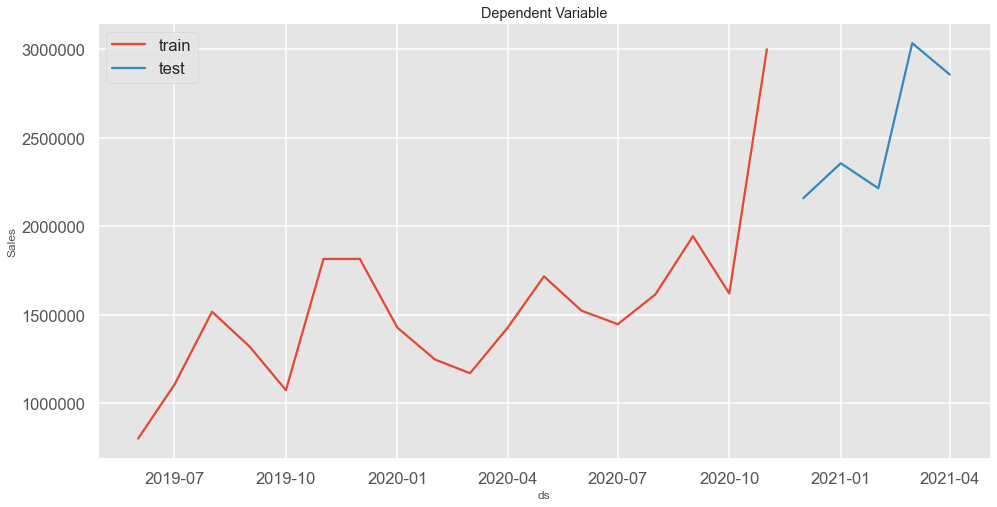

In [9]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x='ds', y='y', label='train', data=train_df, ax=ax)
sns.lineplot(x='ds', y='y', label='test', data=test_df, ax=ax)
plt.ticklabel_format(style='plain', axis='y')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='Sales');
plt.ticklabel_format(style='plain', axis='y')

In [10]:
#training the model on training set
model=Prophet(growth='linear')
model.add_seasonality( name='annually', period=12, fourier_order=1)
model.fit(train_df)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


In [27]:
future=model.make_future_dataframe(periods=7, freq='m')
forecast=model.predict(future)

In [28]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,annually,annually_lower,annually_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-06-01,1060179.332,637892.340,1517995.529,1060179.332,1060179.332,33085.101,33085.101,33085.101,33085.101,33085.101,33085.101,0.000,0.000,0.000,1093264.432
1,2019-07-01,1115028.202,667833.608,1513553.580,1115028.202,1115028.202,-33085.101,-33085.101,-33085.101,-33085.101,-33085.101,-33085.101,0.000,0.000,0.000,1081943.101
2,2019-08-01,1171705.368,889278.453,1683615.357,1171705.368,1171705.368,107865.368,107865.368,107865.368,107865.368,107865.368,107865.368,0.000,0.000,0.000,1279570.736
3,2019-09-01,1228382.534,659928.344,1478289.272,1228382.534,1228382.534,-153743.198,-153743.198,-153743.198,-153743.198,-153743.198,-153743.198,0.000,0.000,0.000,1074639.336
4,2019-10-01,1283231.404,1010208.765,1850487.400,1283231.404,1283231.404,153743.198,153743.198,153743.198,153743.198,153743.198,153743.198,0.000,0.000,0.000,1436974.601


In [29]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,annually,annually_lower,annually_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
20,2021-01-31,2175440.471,1621357.596,2490191.388,2175440.439,2175440.498,-120658.097,-120658.097,-120658.097,-120658.097,-120658.097,-120658.097,0.000,0.000,0.000,2054782.374
21,2021-02-28,2226632.815,1945684.634,2763892.167,2226632.766,2226632.854,153743.198,153743.198,153743.198,153743.198,153743.198,153743.198,0.000,0.000,0.000,2380376.012
22,2021-03-31,2283310.052,1716662.521,2548341.821,2283309.982,2283310.112,-158425.661,-158425.661,-158425.661,-158425.661,-158425.661,-158425.661,0.000,0.000,0.000,2124884.391
23,2021-04-30,2338158.992,2081839.768,2921860.306,2338158.899,2338159.074,158425.661,158425.661,158425.661,158425.661,158425.661,158425.661,0.000,0.000,0.000,2496584.653
24,2021-05-31,2394836.230,1837330.445,2683046.463,2394836.109,2394836.334,-120658.097,-120658.097,-120658.097,-120658.097,-120658.097,-120658.097,0.000,0.000,0.000,2274178.133


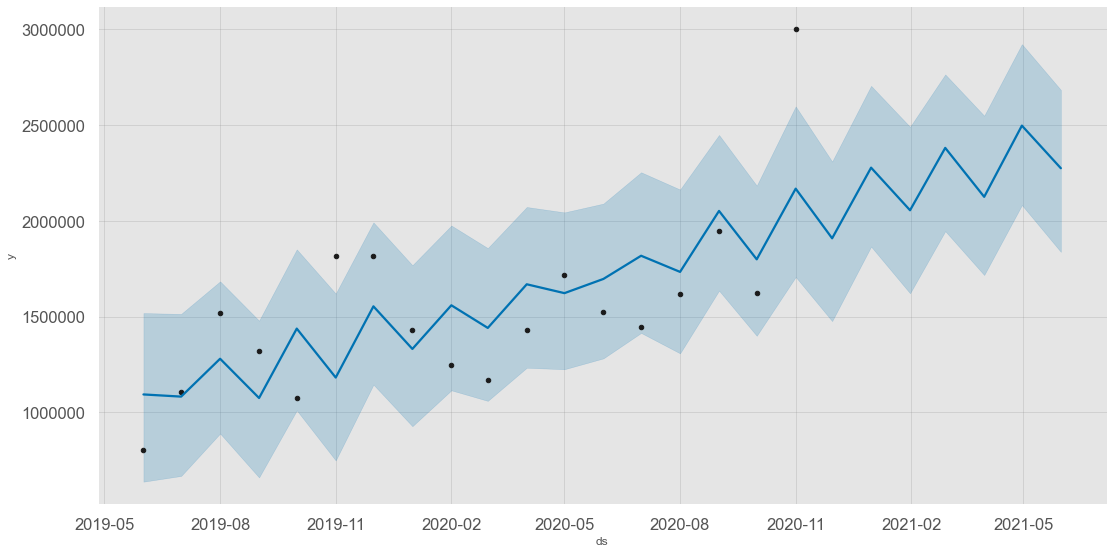

In [30]:
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

fig=model.plot(forecast, ax=ax)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

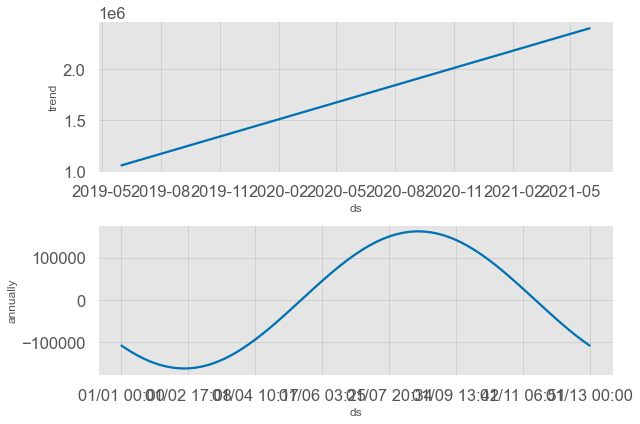

In [31]:
# ploting model components
model.plot_components(forecast)

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

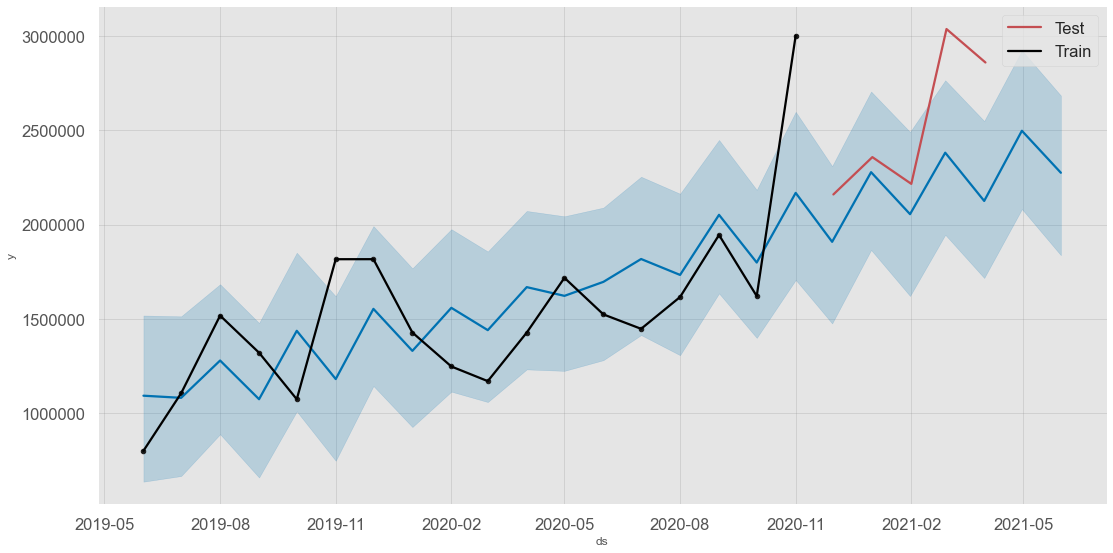

In [49]:
# comparing Forecast to Actual

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


fig=model.plot(forecast, ax=ax)
ax.plot(test_df.ds, test_df.y, color='r', label='Test')
ax.plot(train_df.ds, train_df.y, color='black', label='Train')
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.show


Text(0.5, 1.0, 'One month Forecast Vs Actual, May 01 to 30 , 2021')

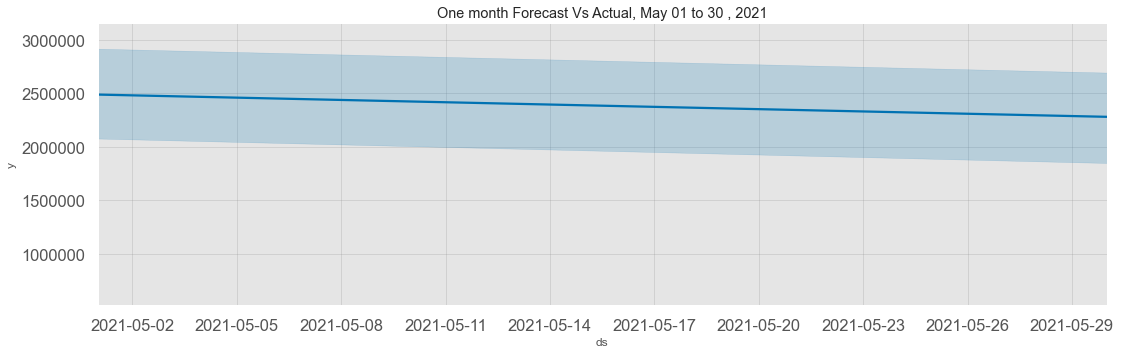

In [33]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
sns.lineplot(test_df['ds'], test_df['y'], color='r', ax=ax)
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-05-01', upper='2021-05-30')
plt.ticklabel_format(style='plain', axis='y')
plt.title('One month Forecast Vs Actual, May 01 to 30 , 2021')

Text(0.5, 1.0, 'One month Forecast, May 07 to June 6, 2021')

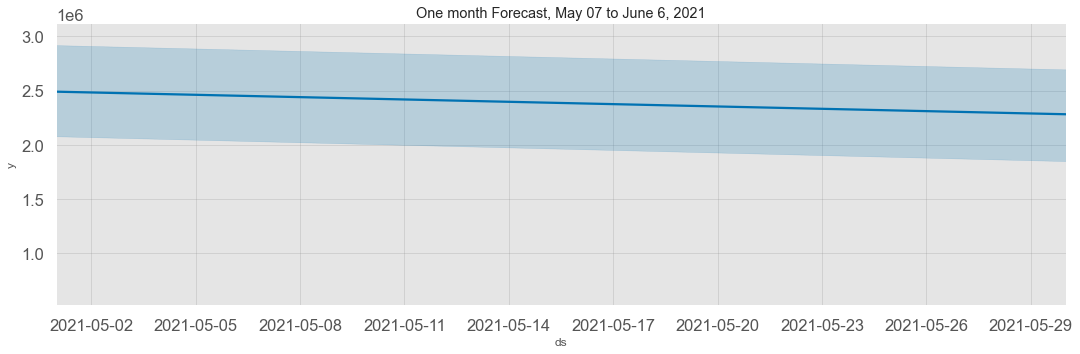

In [34]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-05-01', upper='2021-05-30')

plt.title('One month Forecast, May 07 to June 6, 2021')

In [38]:
# Means Squared Error and RSME
predictions=forecast.yhat[-5:]
mse=mean_squared_error(test_df.y, predictions)
rmse=sqrt(mean_squared_error(test_df.y, predictions))
print('MSE: ', mse)
print('RMSE: ', rmse)

#Mean absolute percentage error (mape)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



MSE:  130233169744.26216
RMSE:  360878.3309430786


In [39]:
# Cross Validation
df_cv=cross_validation(model=model, horizon='30 days', period='30 days')
mape=mean_absolute_percentage_error(df_cv.y, df_cv.yhat)
print('MAPE: ', mape)

# https://www.kaggle.com/robikscube/time-series-forecasting-with-prophet

INFO:fbprophet:Making 14 forecasts with cutoffs between 2019-09-08 00:00:00 and 2020-10-02 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 2.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.
INFO:fbpr


MAPE:  27.955402515520166


In [40]:
### Performance Metrics
from fbprophet.diagnostics import performance_metrics
df_perf = performance_metrics(df_cv)
df_perf.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,23 days,1244524967342.044,1115582.793,1115582.793,1.038,1.038,0.000
1,24 days,108060522835.023,328725.604,328453.053,0.181,0.181,0.000
2,25 days,345458802696.649,587757.435,587545.418,0.456,0.456,0.000
3,26 days,172191634118.959,414959.798,339355.899,0.252,0.120,0.667
4,27 days,26026287287.058,161326.648,148211.652,0.101,0.101,1.000


Text(0.5, 1.0, 'Forecast Vs Actual after Cross Validation')

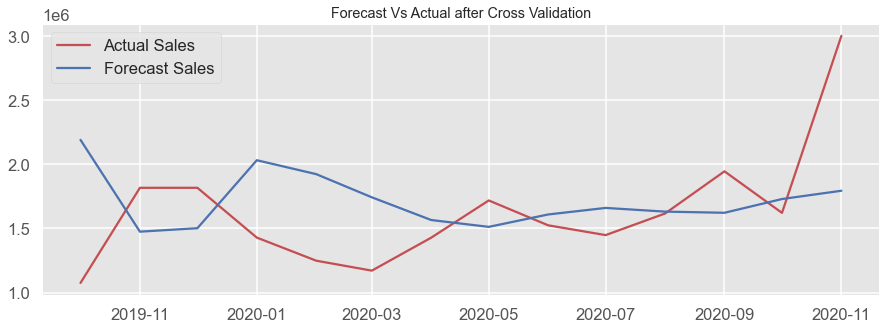

In [41]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(df_cv['ds'], df_cv['y'], color='r', label='Actual Sales')
ax.plot(df_cv['ds'], df_cv['yhat'], color='b', label='Forecast Sales')
plt.legend()



plt.title('Forecast Vs Actual after Cross Validation')

In [42]:
import itertools
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    cutoffs=pd.to_datetime(['2020-03-03','2020-04-28'])
    m = Prophet(**params).fit(train_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

#https://facebook.github.io/prophet/docs/diagnostics.html

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff4cdd3d640>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7ff4cddcfa

    changepoint_prior_scale  seasonality_prior_scale       rmse
0                     0.001                    0.010 152491.009
1                     0.001                    0.100 152491.009
2                     0.001                    1.000 152491.009
3                     0.001                   10.000 152491.009
4                     0.010                    0.010 151242.294
5                     0.010                    0.100 151242.294
6                     0.010                    1.000 151242.294
7                     0.010                   10.000 151242.294
8                     0.100                    0.010 151436.982
9                     0.100                    0.100 151436.982
10                    0.100                    1.000 151436.982
11                    0.100                   10.000 151436.982
12                    0.500                    0.010 412124.385
13                    0.500                    0.100 412124.385
14                    0.500             

In [43]:
final_model=Prophet(growth='linear', changepoint_prior_scale=0.001)
final_model.add_seasonality( name='annually', period=12, fourier_order=1)
final_model.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


In [50]:
future=final_model.make_future_dataframe(periods=7, freq='m')
final_forecast=final_model.predict(future)

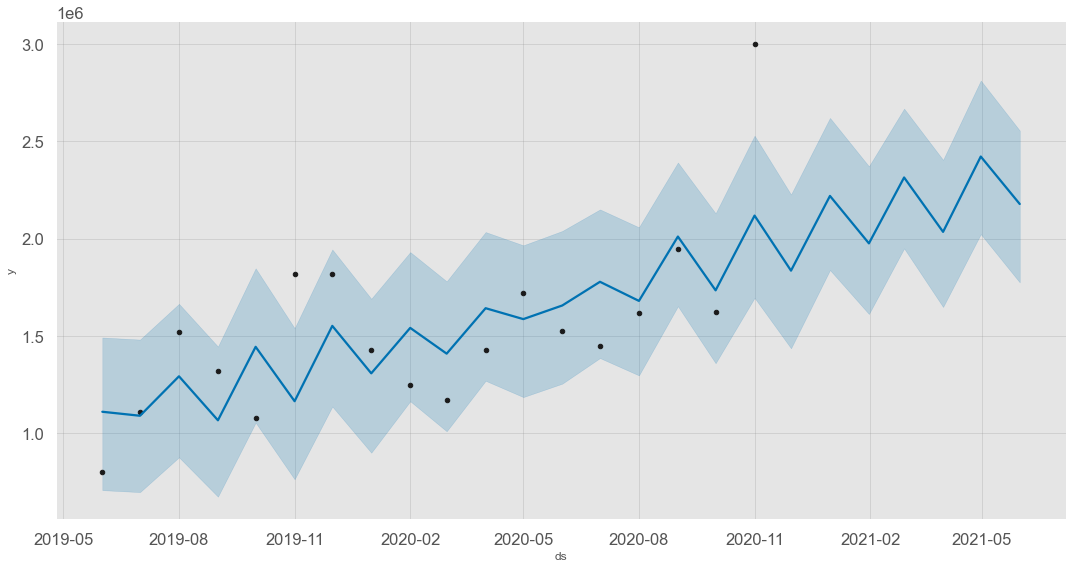

In [51]:
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

fig=final_model.plot(final_forecast, ax=ax)
plt.show()

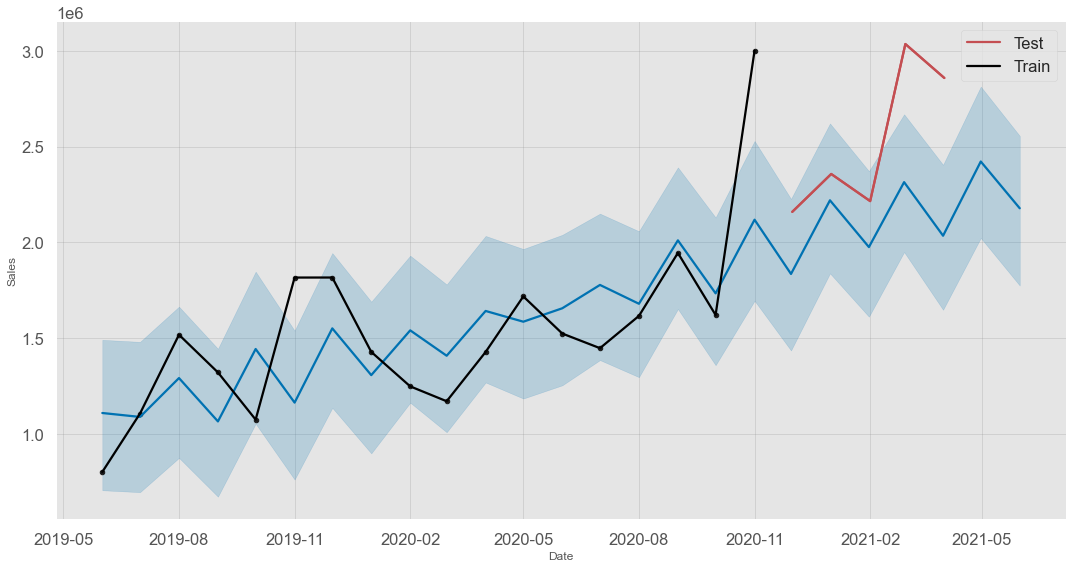

In [59]:
 # comparing Forecast to Actual

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


fig=final_model.plot(final_forecast, ax=ax)
ax.plot(test_df.ds, test_df.y, color='r', label='Test')
ax.plot(train_df.ds, train_df.y, color='black', label='Train')
ax.plot(test_df.ds, test_df.y, color='r')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

Text(95.75, 0.5, 'Sales')

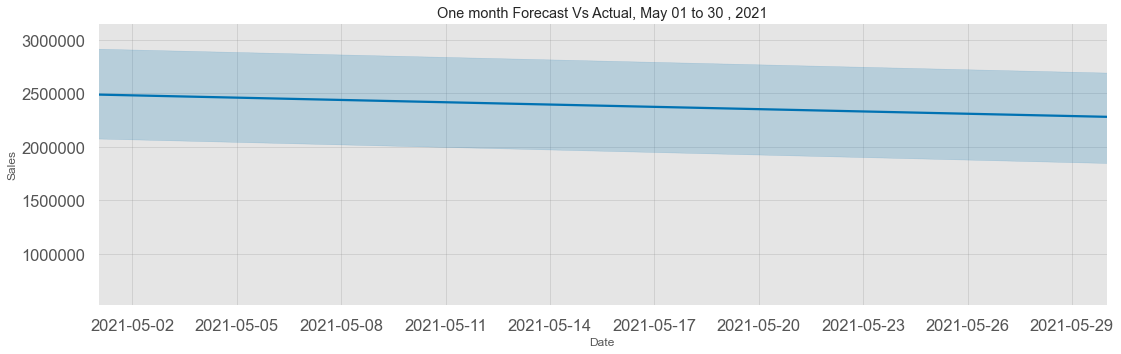

In [57]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
sns.lineplot(test_df['ds'], test_df['y'], color='r', ax=ax)
fig = final_model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-05-01', upper='2021-05-30')
plt.ticklabel_format(style='plain', axis='y')
plt.title('One month Forecast Vs Actual, May 01 to 30 , 2021')
plt.xlabel('Date')
plt.ylabel('Sales')

In [48]:
x_test_forecast=final_model.predict(test_df)
mape=mean_absolute_percentage_error(test_df.y, x_test_forecast.yhat)
print('MAPE: ', mape)

MAPE:  16.18213729761025
